## 11-13. 프로젝트: 뉴스기사 요약해보기
### 학습목표
---

* Extractive/Abstractive summarization 이해하기
* 단어장 크기를 줄이는 다양한 text normalization 적용해보기
* seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

|평가문항|상세기준|
|:---|:---|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

## Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용하세요.
[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary){target="_blank"}

아래의 코드로 데이터를 다운로드 할 수 있어요.

In [8]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/ssac15/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [10]:
data.sample(10)

,headlines,text
12594,85-year-old Paul Biya wins 7th term as Cameroo...,Cameroon's 85-year-old Paul Biya has won the p...
80619,BMC notice to NGO for report on malnutrition i...,The Brihanmumbai Municipal Corporation (BMC) h...
5232,Sultanpur should be again called 'Kushbhawanpu...,"Devmani Dwivedi, a BJP MLA from Uttar Pradesh,..."
50677,"Never bowed to US in past, don't plan to: Paki...",Pakistan Foreign Minister Khawaja Muhammad Asi...
83894,Fitness blogger killed by exploding whipped cr...,A 33-year-old French fitness blogger passed aw...
60545,Disaster management body gives dogs heli-slith...,The National Disaster Response Force (NDRF) ha...
5283,All good things must come to an end: McCullum ...,Former New Zealand cricket team captain Brendo...
91434,116-yr-old Mexican woman denied bank card for ...,"Maria Felix, a 116-year-old woman from Mexico,..."
549,Not true: Saif on playing Sara's father in 'Lo...,Denying the reports that said Saif Ali Khan wi...
43900,Chennai has fastest fixed broadband speed in I...,"Among Indian cities, Chennai has the fastest f..."


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [11]:
data = data[['text','headlines']]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

#### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [12]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [13]:
#tex에서 중복 41개 / headlines 중복 121개
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))


전체 샘플수 : 98360


In [14]:
#데이터에 Null 값이 남아있는지 확인

print(data.isnull().sum())

text         0
headlines    0
dtype: int64


#### 텍스트 정규화와 불용어 제거

In [15]:
#텍스트 정규화와 불용어 제거

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [16]:
#NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [17]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [18]:
#전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 headlines 만들어 함수를 호출해서 결과 확인.

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [19]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [20]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [21]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [22]:
data.isnull().sum()

text         0
headlines    0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


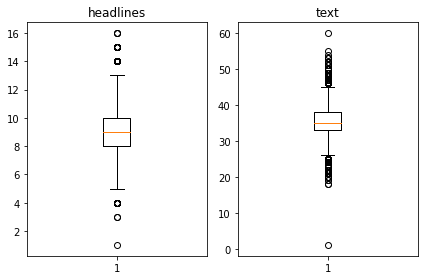

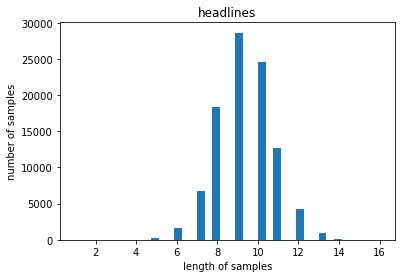

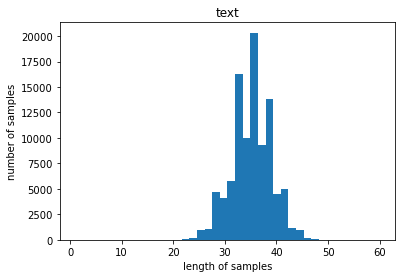

In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 데이터 정제

In [24]:
#이로부터 text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해볼게요.
text_max_len = 50
headlines_max_len = 8

In [25]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [26]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


In [27]:
#정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 27105


#### 시작 토큰과 종료 토큰 추가하기

In [28]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
19,union minister dharmendra pradhan wednesday cl...,odisha cm patnaik controls mining mafia union ...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,indian space research organisation wednesday u...,isro unveils bengaluru centre for manned space...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,least people killed others injured saudi arabi...,killed injured in saudi arabia floods,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,investigators searching lost plane carrying ar...,seat cushions from missing plane carrying foot...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland chopper scam co accused rajiv s...,agustawestland scam accused rajiv saxena extra...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


In [29]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [30]:
#인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 8684 26377  3887 ... 21914 13824 26464]


#### 훈련 데이터와 테스트 데이터를 분리

In [31]:
#데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 5421


In [32]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


### 데이터 전처리하기 (3) 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 

In [33]:
# Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [34]:
#빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 41668
등장 빈도가 6번 이하인 희귀 단어의 수: 30011
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11657
단어 집합에서 희귀 단어의 비율: 72.02409522895267
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.092262045673342


encoder_input_train에는 총 21,684개의 단어가 있네요. 

등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지하네요. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 8.09%밖에 되지 않아요.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 11,657으로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 11,000으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [35]:
src_vocab = 11000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [36]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

#이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있어요.

[[147, 13, 4153, 3784, 55, 45, 551, 2591, 7357, 1399, 3387, 405, 125, 5730, 6426, 18, 49, 61, 6426, 6, 39, 360, 7, 1399, 642, 812, 597, 865, 39, 360, 5, 2218, 8607, 4907, 8], [14, 204, 489, 439, 55, 638, 246, 204, 326, 211, 150, 9, 8608, 204, 857, 281, 3263, 1, 211, 1194, 269, 1660, 1307, 1005, 7026, 204, 1005, 4051, 787, 4, 7027, 865, 3128, 246, 204, 326, 3453, 3263, 6], [101, 7, 64, 142, 172, 445, 970, 148, 84, 4386, 798, 2629, 736, 189, 1322, 7, 4387, 506, 678, 798, 2219, 286, 3691, 1571, 987, 445, 970, 317, 453, 4281]]


In [37]:
#headlines 데이터에 대해서도 동일한 작업을 수행

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [38]:
#tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보를 얻어서, 
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18718
등장 빈도가 5번 이하인 희귀 단어의 수: 14060
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4658
단어 집합에서 희귀 단어의 비율: 75.1148626990063
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.890331874876155


In [39]:
tar_vocab = 4000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 653, 58, 1628, 271, 37], [1, 984, 205, 67, 173, 5, 221, 719], [1, 30, 100, 3, 135, 554, 467], [1, 2367, 9, 209, 346, 872, 591, 82], [1, 3323, 677, 111, 2549, 4, 8]]
target
decoder  [[653, 58, 1628, 271, 37, 2], [984, 205, 67, 173, 5, 221, 719, 2], [30, 100, 3, 135, 554, 467, 2], [2367, 9, 209, 346, 872, 591, 82, 2], [3323, 677, 111, 2549, 4, 8, 2]]


#### 패딩하기

In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 3
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 21681
훈련 레이블의 개수 : 21681
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


In [41]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

### 모델 설계하기

In [42]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작 
#hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터

embedding_dim = 128 # 임베딩 벡터의 차원은 128로 정의
hidden_size = 256  #  hidden state의 크기를 256으로 정의

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [43]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [50]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1408000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야한다는 뜻

In [51]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [52]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1408000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [53]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
85/85 [==============================] - 31s 367ms/step - loss: 5.9999 - val_loss: 5.4620
Epoch 2/50
85/85 [==============================] - 30s 353ms/step - loss: 5.5135 - val_loss: 5.3124
Epoch 3/50
85/85 [==============================] - 31s 362ms/step - loss: 5.3075 - val_loss: 5.0965
Epoch 4/50
85/85 [==============================] - 32s 372ms/step - loss: 5.1495 - val_loss: 4.9954
Epoch 5/50
85/85 [==============================] - 30s 357ms/step - loss: 5.0020 - val_loss: 4.8738
Epoch 6/50
85/85 [==============================] - 30s 348ms/step - loss: 4.8530 - val_loss: 4.8018
Epoch 7/50
85/85 [==============================] - 30s 349ms/step - loss: 4.7012 - val_loss: 4.7109
Epoch 8/50
85/85 [==============================] - 30s 349ms/step - loss: 4.5613 - val_loss: 4.6381
Epoch 9/50
85/85 [==============================] - 30s 355ms/step - loss: 4.4184 - val_loss: 4.5794
Epoch 10/50
85/85 [==============================] - 31s 368ms/step - loss: 4.2806 - val_lo

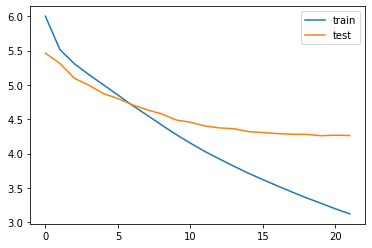

In [55]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 인퍼런스 모델 구현하기

In [56]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [57]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [58]:
# 어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [64]:
#인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

### 모델 테스트하기

In [67]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [68]:
#테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : pope francis replaced conservative german department responsible defending catholic publicly criticised pope earlier succeeded department number two luis francisco notably department deals priests accused child sex abuse among things 
실제 요약 : pope replaces vatican chief 
예측 요약 :  former prez appointed as of


원문 : bowler mitchell among australian cricketers unemployed contracts expired trying golf posted picture instagram captioned thought would better give another profession go unemployed yet absolute treat top australian cricketers unemployed new deal struck cricket australia players union 
실제 요약 : australian cricketer tries hand at 
예측 요약 :  australia to play in


원문 : indian air force denied service extension lady officer rank leader since found well suffering officer completed years short service commission officer sought four year extension approached military court stayed iaf order 
실제 요약 : iaf woman officer denied extension for being 
예측 요약 :  indians in months after sex



예측 요약 :  australian club passes away aged


원문 : bharatiya janata party chief amit shah said saturday party ban beef state goa law cow slaughter passed congress regime plans ban beef said day trip state 
실제 요약 : no plan to ban beef in goa bjp 
예측 요약 :  bjp leader threatens to declare bjp


원문 : uttarakhand chief minister trivendra singh rawat sunday rescued man lying unconscious road minister seeing unconscious man immediately went directed officials carry one convoy cars take hospital rawat stayed situation completely taken care 
실제 요약 : uttarakhand cm rescues man on road 
예측 요약 :  maharashtra police suspended for protesting in maharashtra


원문 : least people killed others injured suicide bomber blew syrian capital sunday reports said bomber one three cars carrying bombs chased syrian authorities bombs destroyed police separate location western 
실제 요약 : killed injured in suicide bombing in syria 
예측 요약 :  killed injured in twin suicide in afghanistan


원문 : barcelona forward lionel me

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

### summarize 사용하기
* Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행
* 원문의 0.1%만 요약문으로 선택되도록 문장의 개수 조정

In [157]:
import os
import csv
import requests
from summa.summarizer import summarize

In [155]:
data = os.getenv('HOME')+'/aiffel/e11.news_summarization/news_summary_text.csv'

In [ ]:
f = open('news_summary_text.csv', 'r', encoding='utf-8-sig')
rdr = csv.reader(f)
#for line in rdr:
#    print(line)
#f.close() 

# 데이터 로딩이 길어서 닫음. CSV 파일 내용 확인 하는 코드

In [172]:
print(type(f))

<class '_io.TextIOWrapper'>


In [200]:
print('Headlines:')
print(summarize(data, language='english', ratio=0.5, words=10, split=True))

Headlines:
[]


### 두번째 방법

In [194]:
csv2 = pd.read_csv('news_summary_text.csv', names = ['text'], encoding="utf-8" )

In [195]:
data2 = csv2['text']
print(data2[:5])

0                                                 text
1    Saurav Kant, an alumnus of upGrad and IIIT-B's...
2    Kunal Shah's credit card bill payment platform...
3    New Zealand defeated India by 8 wickets in the...
4    With Aegon Life iTerm Insurance plan, customer...
Name: text, dtype: object


In [202]:
data2_col = data2.values
print(data2_col[:10])

['text'
 "Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
 "Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
 "New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. 

In [197]:
tran_data2_col = str(data2_col)

In [207]:
print('Headlines:')
print(summarize(tran_data2_col, language='english', ratio=0.1))

Headlines:
"According to reports, a new version of the 1999 science fiction film 'The Matrix' is in development.


In [211]:
print('Headlines:')
print(summarize(tran_data2_col, language='english', ratio=0.08))

Headlines:
"According to reports, a new version of the 1999 science fiction film 'The Matrix' is in development.


In [213]:
print('Headlines:')
print(summarize(tran_data2_col, language='english', ratio=0.6))

Headlines:
"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience.
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
"According to reports, a new version of the 1999 science fiction film 'The Matrix' is in development.
Michael B Jordan will reportedly play the lead role in the film.
Screenwriter Zak Penn is in talks to write the script of the film, reports added.
"A new music video shows rapper Snoop Dogg aiming a toy gun at a clown character parodying US President Donald Trump.
The video also shows a TV airing a news conference with the headline 'Ron

In [214]:
print('Headlines:')
print(summarize(tran_data2_col, language='english', words=10))

Headlines:
"According to reports, a new version of the 1999 science fiction film 'The Matrix' is in development.


In [221]:
print('Headlines:')
print(summarize(tran_data2_col, language='english', words=9))

Headlines:
"According to reports, a new version of the 1999 science fiction film 'The Matrix' is in development.


## 총평

분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행하였다.
모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으나, 실제 요약문과 예측 요약문이 유사하다고 판단하기 어려워 보인다. 

추출적 모델은 다른 모델을 고려해보야 한다. 뉴스 데이터의 경우 헤드라인을 추출하기 어렵다. 
데이터 전처리 없이 원문을 넣으면 된다고 했으나, 원문 전체를 읽어오지 못했다. 
추출적 요약 모델은 ratio=0.4이상의 요약문 적정해 보인다. 0.1 이하의 헤드라인과 같은 짧은 요약은 추출해 내지 못했다. 

Summa.summarize에 데이터를 넣기가 생각보다 어려웠지만, 저렇게라도 성공해서 눈물날 뻔 했다. 다른 모델도 해보면, 좀 더 확실한 비교가 될 수 있을것같아서, 학습의욕이 마구마구 생기는 task였다. ^^
